# Train and Deploy a Fastai v1 Image Classification Model on Azure Machine Learning 

In this notebook we will do the following: 

1) Train a model locally with Azure Compute Instance (CI).
2) Log metrics to Azure Machine Learning. 
3) Learn how to register a model in your Azure Machine Learning Workspace.
4) Deploy your model as a web service in an Azure Container Instance (ACI) and call the webservice. 

In [1]:
#This is to ensure that any edits to libraries you make are reloaded here automatically, and also that any charts or images displayed are shown in this notebook.
%reload_ext autoreload
%autoreload 2
%matplotlib inline

We import all the necessary packages. We are going to work with the fastai V1 library (Pytorch 1.0). The fastai library provides many useful functions that enable us to quickly and easily build neural networks and train our models.

In [2]:
!pip install fastai
from fastai.vision import *
from fastai.metrics import error_rate

# Connect to Workspace 

Create a workspace object from the existing workspace. Workspace.from_config() reads the file config.json and loads the details into an object named ws.

In [4]:
import azureml 
from azureml.core import Workspace

ws = Workspace.from_config()
print(ws.get_details())

{'id': '/subscriptions/15ae9cb6-95c1-483d-a0e3-b1a1a3b06324/resourceGroups/PipelinesUsabilityStudy/providers/Microsoft.MachineLearningServices/workspaces/shwinneworkshop', 'name': 'shwinneworkshop', 'location': 'eastus2', 'type': 'Microsoft.MachineLearningServices/workspaces', 'tags': {}, 'sku': 'Enterprise', 'workspaceid': '2c99da6f-e7fc-4070-b1f7-204807455abf', 'description': '', 'friendlyName': '', 'creationTime': '2020-01-13T20:47:53.0433365+00:00', 'containerRegistry': '/subscriptions/15ae9cb6-95c1-483d-a0e3-b1a1a3b06324/resourceGroups/PipelinesUsabilityStudy/providers/Microsoft.ContainerRegistry/registries/shwinneworks933cbd9b', 'keyVault': '/subscriptions/15ae9cb6-95c1-483d-a0e3-b1a1a3b06324/resourcegroups/pipelinesusabilitystudy/providers/microsoft.keyvault/vaults/shwinneworksho8870415227', 'applicationInsights': '/subscriptions/15ae9cb6-95c1-483d-a0e3-b1a1a3b06324/resourcegroups/pipelinesusabilitystudy/providers/microsoft.insights/components/shwinneworksho2947248937', 'identit

# Dataset 

We are going to use the Food 101 dataset (https://www.kaggle.com/kmader/food41#1028787.jpg ) which features 101 food categories, with 101'000 images. For each class, 250 manually reviewed test images are provided as well as 750 training images. For the purpose of this notebook, we will be classifying amongst 5 different food categories (applie pie, waffles, padthai, bread pudding and ramen). We will be using only 200 images per food category. We will use a training set of 160 images and a validation set of 60 images for each class of food. 

Please download the images from Kaggle into separate folders and create 5 datasets for each of the categories of food by following the instructions in the prepare-dataset.md file.

In [ ]:
#Get and download food images from the 'File Datasets' from your workspace.
#Create directories for your classes and choose an appropriate folder name for your labeled images.

from azureml.core import Dataset

apple_pie_dataset = Dataset.get_by_name(ws, name='apple-pie')
apple_pie_dataset.download(target_path='./data/apple-pie', overwrite=False)

waffles_dataset = Dataset.get_by_name(ws, name='waffles')
waffles_dataset.download(target_path='./data/waffles', overwrite=False)

padthai_dataset = Dataset.get_by_name(ws, name='pad-thai')
padthai_dataset.download(target_path='./data/padthai', overwrite=False)

breadpudding_dataset = Dataset.get_by_name(ws, name='bread-pudding')
breadpudding_dataset.download(target_path='./data/breadpudding', overwrite=False)

ramen_dataset = Dataset.get_by_name(ws, name='ramen')
ramen_dataset.download(target_path='./data/ramen', overwrite=False)

In [6]:
import pathlib
from pathlib import Path

#list the directories to the images 
path = Path('data')
path.ls()

[PosixPath('data/.ipynb_checkpoints'),
 PosixPath('data/apple-pie'),
 PosixPath('data/breadpudding'),
 PosixPath('data/models'),
 PosixPath('data/padthai'),
 PosixPath('data/ramen'),
 PosixPath('data/waffles')]

In [7]:
#These are the classes for your food categories

classes = ['apple-pie','breadpudding','padthai', 'ramen', 'waffles']

In [8]:
#Remove any images that cannot be opened. 

for c in classes:
    print(c)
    verify_images(path/c, delete=True, max_size=2200)

apple-pie


breadpudding


padthai


ramen


waffles


# View Data

ImageDataBunch returns a data bunch object which is needed for modeling in fast AI. This contains the images and labels for the training, validation and/or test datasets. 

We want to ensure that all images are the same shape and size for better GPU performance. We will use size = 224 to ensure that all the images are of 224x224 square size.

If the data is not normalized, we can have difficulty training a model. We want the red, green and blue channels of the images to have a mean of 0 and standard deviation of 1. The get_transforms function ensures that the image sizes are 224 x 224 by doing a combination of techniques such as center cropping and resizing. 

In [9]:
np.random.seed(42)
data = ImageDataBunch.from_folder(path, train=".", valid_pct=0.2,
        ds_tfms=get_transforms(), size=224).normalize(imagenet_stats)

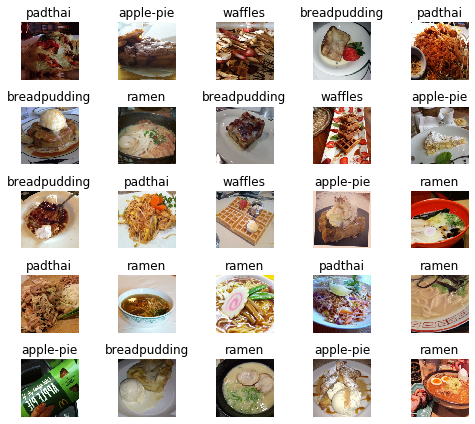

In [10]:
#let's take a look at our delicious food! Yummm....

data.show_batch(rows=5, figsize=(7,6))

In [11]:
data.classes, data.c, len(data.train_ds), len(data.valid_ds)

(['apple-pie', 'breadpudding', 'padthai', 'ramen', 'waffles'], 5, 800, 200)

# Training 

For more information on Convolutional Neural Networks please see http://cs231n.github.io/convolutional-networks/ .We will train a CNN to classify food images for 5 types of food. 

In [12]:
#create your model called 'learn'

learn = cnn_learner(data, models.resnet34, metrics=accuracy)

In [13]:
learn.fit_one_cycle(4)

In [14]:
#Export the model. This step is important if you want to perform inferencing. 

learn.path = Path(".") 
learn.export()
path = learn.path
path

PosixPath('.')

In [15]:
#scoring using fastai 
img = open_image('data/apple-pie/3068872.jpg')
img
pred_class,pred_idx,outputs = learn.predict(img)
pred_class

Category apple-pie

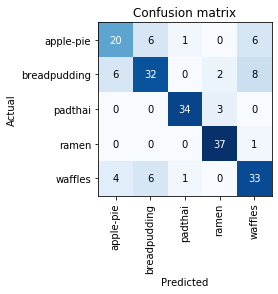

In [16]:
interp = ClassificationInterpretation.from_learner(learn)
interp.plot_confusion_matrix()

# Create Experiment 

Create an experiment to track the runs in your workspace. A workspace can have multiple experiments.

In [17]:
from azureml.core import Experiment, Run

#create new AML experiment 
experiment = Experiment(ws, 'fastai-food-classification')

In [1]:
%%writefile train.py

from fastai.vision import (ImageDataBunch, get_transforms, cnn_learner, models, imagenet_stats, accuracy)
from pathlib import Path 
from azureml.core.run import Run 
import numpy as np

# get the Azure ML run object
run = Run.get_context()

# get images
path = Path('data')
np.random.seed(2)
data = ImageDataBunch.from_folder(path,
                                       train=".",
                                       valid_pct=0.2,
                                       ds_tfms=get_transforms(),
                                       size=224).normalize(imagenet_stats)

# build estimator based on ResNet 34
learn = cnn_learner(data, models.resnet34, metrics=accuracy)
learn.fit_one_cycle(2)

# do test time augmentation and get accuracy
acc = accuracy(*learn.TTA())


# log the accuracy to run
run.log('Accuracy', np.float(acc))
print("Accuracy: ", np.float(acc))

# Save the model to the root. Note: this is not registering model
#learn.path = Path(".")
#learn.export()
#path = learn.path
#path

Writing train.py


# System-managed environment 

Now, instead of managing the setup of the environment yourself, you can ask the system to build a new conda environment for you. The environment is built once, and will be reused in subsequent executions as long as the conda dependencies remain unchanged.

In [21]:
from azureml.core.environment import CondaDependencies
from azureml.core import Environment
from azureml.core import ScriptRunConfig


#If your total snapshot size exceeds the limit of 300.0 MB, uncomment the below line. Please see http://aka.ms/aml-largefiles on how to work with large files.
azureml._restclient.snapshots_client.SNAPSHOT_MAX_SIZE_BYTES = 5000000000

myenv = Environment(name="myenv")
conda_dep = CondaDependencies()
conda_dep.add_pip_package("fastai")
conda_dep.add_pip_package("ipykernel")
myenv.python.conda_dependencies=conda_dep

myenv.python.user_managed_dependencies = False

#To submit a run, create a run configuration that combines the script file and environment, and pass it to Experiment.submit. 
#In this example, the script is submitted to local computer, but you can specify other compute targets such as remote clusters as well.

runconfig = ScriptRunConfig(source_directory=".", script="train.py")
runconfig.run_config.target = "local"
runconfig.run_config.environment = myenv
run = experiment.submit(config=runconfig)

run.wait_for_completion(show_output=True)

RunId: fastai-food-classification_1585270168_ec66b6de
Web View: https://ml.azure.com/experiments/fastai-food-classification/runs/fastai-food-classification_1585270168_ec66b6de?wsid=/subscriptions/15ae9cb6-95c1-483d-a0e3-b1a1a3b06324/resourcegroups/pipelinesusabilitystudy/workspaces/shwinneworkshop

Execution Summary
RunId: fastai-food-classification_1585270168_ec66b6de
Web View: https://ml.azure.com/experiments/fastai-food-classification/runs/fastai-food-classification_1585270168_ec66b6de?wsid=/subscriptions/15ae9cb6-95c1-483d-a0e3-b1a1a3b06324/resourcegroups/pipelinesusabilitystudy/workspaces/shwinneworkshop



{'runId': 'fastai-food-classification_1585270168_ec66b6de',
 'target': 'local',
 'status': 'Completed',
 'startTimeUtc': '2020-03-27T00:50:50.98713Z',
 'endTimeUtc': '2020-03-27T00:51:40.943921Z',
 'properties': {'_azureml.ComputeTargetType': 'local',
  'ContentSnapshotId': 'e5c25456-b862-464b-a858-d55d595e1c67'},
 'inputDatasets': [],
 'runDefinition': {'script': 'train.py',
  'useAbsolutePath': False,
  'arguments': [],
  'sourceDirectoryDataStore': None,
  'framework': 'Python',
  'communicator': 'None',
  'target': 'local',
  'dataReferences': {},
  'data': {},
  'jobName': None,
  'maxRunDurationSeconds': None,
  'nodeCount': 1,
  'environment': {'name': 'myenv',
   'version': 'Autosave_2020-02-25T03:31:01Z_032f0153',
   'python': {'interpreterPath': 'python',
    'userManagedDependencies': False,
    'condaDependencies': {'channels': ['conda-forge'],
     'dependencies': ['python=3.6.2',
      {'pip': ['azureml-defaults', 'fastai', 'ipykernel']}],
     'name': 'azureml_fee5e6a925

In [ ]:
from azureml.widgets import RunDetails 
RunDetails(run).show()

#Register Model

Register a file or folder as a model by calling [Model.register()](https://docs.microsoft.com/en-us/python/api/azureml-core/azureml.core.model.model?view=azure-ml-py#register-workspace--model-path--model-name--tags-none--properties-none--description-none--datasets-none--model-framework-none--model-framework-version-none--child-paths-none-). In addition to the content of the model file itself, your registered model will also store model metadata, model description, tags, and framework information that will be useful when managing and deploying models in your workspace. Using tags, for instance, you can categorize your models and apply filters when listing models in your workspace. Also, marking this model with the scikit-learn framework will simplify deploying it as a web service, as we'll see later.


In [24]:
from azureml.core.model import Model

#Register the model
model = Model.register(model_path = "export.pkl", # this points to a local file
                       model_name = "food_classification_model2", # this is the name the model is registered as
                       tags = {'food': "Yummmm :)"},
                       description = "Model predicting types of food",
                       workspace = ws)

print(model.name, model.description, model.version)

Registering model food_classification_model2
food_classification_model2 Model predicting types of food 28


# Prepare to deploy


To deploy the model, you need the following items:

1) An entry script, this script accepts requests, scores the requests by using the model, and returns the results.

2) Dependencies, like helper scripts or Python/Conda packages required to run the entry script or model.

3) The deployment configuration for the compute target that hosts the deployed model. This configuration describes things like memory and CPU requirements needed to run the model.

Define your entry script and dependencies

We will first write the entry script as shown below. Note a few points in the entry script.

The script contains two functions that load and run the model:

init(): Typically, this function loads the model into a global object. This function is run only once, when the Docker container for your web service is started. Ensure to make your global declarations inside of the init() function. 

run(request): This function uses the model to predict a value based on the input data. Inputs and outputs of the run typically use JSON for serialization and deserialization. You can also work with raw binary data. You can transform the data before sending it to the model or before returning it to the client.

The fastai predict function returns the object predicted (with the class in this instance), the underlying data (here the corresponding index) and the raw probabilities. You can also do inference on a larger set of data by adding a test set. This is done by passing an ItemList to load_learner. Please see https://docs.fast.ai/tutorial.inference.html for more information. 

In [25]:
%%writefile score.py

import os
import json
from azureml.core.model import Model
from azureml.core import Workspace
import fastai 
from fastai.vision import *
from fastai.metrics import accuracy 
from fastai.metrics import error_rate
import urllib.request


def download_jpg(url):
    file_path = "./breadpudding.jpg"
    local_filename, header = urllib.request.urlretrieve(url, file_path)    
    return local_filename

def init():   
    global food_classification_model
    # The AZUREML_MODEL_DIR environment variable indicates a directory containing the model file you registered.  
    #this init works 
    model_path=os.getenv('AZUREML_MODEL_DIR')     
    filename="export.pkl"
    classes = ['apple-pie','breadpudding','padthai', 'ramen', 'waffles']
    food_classification_model = load_learner(path=model_path, file=filename)   
    classes = food_classification_model.data.classes
    print(classes)


def run(request):   
    candidate_url = json.loads(request)["url"]   
    file_path = download_jpg(candidate_url)
    img = open_image(file_path)
    prediction = food_classification_model.predict(img)
    index = 0
    pred = str(prediction[index])
    print(pred)
    return pred


# if __name__ == "__main__":
#     init()  
#     request = { "url": "https://i.imgur.com/TqlREOJ.jpg"}
#     run(request)
#     print("main")

Overwriting score.py


Define dependencies
The following YAML is the Conda dependencies file we will use for inference. If you want to use automatic schema generation, your entry script must import the inference-schema packages.

In [26]:
%%writefile myenv.yml

name: project_environment
dependencies:
- python=3.6.9

- pip:
  - fastai==1.0.60
  - torch
  - torchvision  
  - azureml-defaults
  - azureml-core
  - matplotlib==3.1.2
- numpy==1.16.2
- Pillow==6.2.0
- pandas==0.23.4



Overwriting myenv.yml


In [27]:
from azureml.core import Environment

# Instantiate environment
myenv = Environment.from_conda_specification(name = "myenv",
                                             file_path = "myenv.yml")

Define your inference configuration. The inference configuration describes how to configure the model to make predictions. This configuration isn't part of your entry script. It references your entry script and is used to locate all the resources required by the deployment. It's used later, when you deploy the model.


In [28]:
from azureml.core.model import InferenceConfig

inference_config = InferenceConfig(entry_script='score.py', environment=myenv)

# Deploy Model

Before deploying your model, you must define the deployment configuration. The deployment configuration is specific to the compute target that will host the web service. The deployment configuration isn't part of your entry script. It's used to define the characteristics of the compute target that will host the model and entry script.

You can customize the deploy configuration (i.e. the number of cores and amount of memory made available for the deployment) using the [AciWebservice.deploy_configuration()](https://docs.microsoft.com/python/api/azureml-core/azureml.core.webservice.aci.aciwebservice#deploy-configuration-cpu-cores-none--memory-gb-none--tags-none--properties-none--description-none--location-none--auth-enabled-none--ssl-enabled-none--enable-app-insights-none--ssl-cert-pem-file-none--ssl-key-pem-file-none--ssl-cname-none--dns-name-label-none--).
        
**Note**: This step can take several minutes.

In [29]:
from azureml.core.webservice import AciWebservice

aciconfig = AciWebservice.deploy_configuration(cpu_cores=1, 
                                               memory_gb=1, 
                                               tags = {'task': "image-classification"}, 
                                               description='A model to predict types of food')

Deployment uses the inference configuration deployment configuration to deploy the models. The deployment process is similar regardless of the compute target

In [35]:
service = Model.deploy(ws, name='food-classification-aci', models=[model], inference_config= inference_config, deployment_config=aciconfig)
service.wait_for_deployment(True)
print(service.state)

Running...............................................
Succeeded
ACI service creation operation finished, operation "Succeeded"
Healthy


After your model is deployed, make a call to the web service using [service.run()](https://docs.microsoft.com/en-us/python/api/azureml-core/azureml.core.webservice%28class%29?view=azure-ml-py#run-input-).

In [38]:
import json
  
request = json.dumps({"url": "https://i.imgur.com/TqlREOJ.jpg"})
prediction = service.run(request)
print(prediction)

breadpudding


When you are finished testing your service, clean up the deployment with [service.delete()](https://docs.microsoft.com/en-us/python/api/azureml-core/azureml.core.webservice%28class%29?view=azure-ml-py#delete--).

In [ ]:
service.delete()